In [1]:
import numpy as np
import pandas as pd
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from support import query_data
%matplotlib inline

In [2]:
db = sqlite3.connect("/data/amazon-fine-foods/amazon-fine-foods/database.sqlite")

# Model Fitting
I initially considered three models: RandomForest, MultinomialNB and BernoulliNB. Below we are constructing the pipeline to vectorize the text and then fit the RandomForestClassifier to it. The following process was extensively iterated upon which explains some of the reason why sections below look scattered. I initally started with most of the reasonable parameters in RandomForest and TfidfVectorizer and then slowly limited the values I searched over until I no longer saw improvment. Once I found a value I liked I added it to the pipeline and focused on the remaining parameters. This process is important as running GridSearchCV on every possible parameter initially would have taken days. Note: This data set can take an extremely long time. Some functions can take hours and require multiple threads. The current state of the notebook will take around 30 mintes.

In [3]:
PUNCTUATION = '`~!@#$%^&*()_-+={[}]|\:;"<,>.?/}\t\n'
def process(x):
    """
    Basic Preprocessor to remove punctuation from words. 
    """
    return x.strip(PUNCTUATION)

In [4]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(preprocessor=process, norm='l1', ngram_range=(1, 2), max_df=1.0)),
    ('rf', RandomForestClassifier(n_estimators=500)),
])

The following pipelined paramaters can be modified in the parameters section when GridSearchCV iterates over them. The GridSearchCV process can take an extremely long time so be cautious when running the following cells. 

In [5]:
TfidfVectorizer().get_params().keys()

dict_keys(['tokenizer', 'encoding', 'input', 'norm', 'stop_words', 'binary', 'smooth_idf', 'sublinear_tf', 'vocabulary', 'analyzer', 'min_df', 'decode_error', 'token_pattern', 'ngram_range', 'use_idf', 'strip_accents', 'max_df', 'preprocessor', 'lowercase', 'dtype', 'max_features'])

In [6]:
RandomForestClassifier().get_params().keys()

dict_keys(['verbose', 'oob_score', 'min_weight_fraction_leaf', 'bootstrap', 'min_samples_leaf', 'max_features', 'criterion', 'class_weight', 'warm_start', 'n_jobs', 'max_depth', 'random_state', 'max_leaf_nodes', 'min_samples_split', 'n_estimators'])

In [7]:
parameters = {
    'tfidf__max_features': (18000, 19000, 20000)
}

In [8]:
reviews, rev_count, user_count = query_data(75, db) 

In [9]:
X = reviews["Text"]
y = reviews["UserId"]

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [11]:
grid_search = GridSearchCV(pipeline, parameters, n_jobs=4, verbose=1, cv=3)

In [12]:
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=4)]: Done   9 out of   9 | elapsed:  5.8min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), norm='l1',
        preprocessor=<function proces...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
       fit_params={}, iid=True, n_jobs=4,
       param_grid={'tfidf__max_features': (18000, 19000, 20000)},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=1)

In [13]:
grid_search.best_params_

{'tfidf__max_features': 19000}

In [14]:
res_forest = grid_search.best_estimator_

In [15]:
model = res_forest.fit(X_train, y_train)

In [16]:
y_pred_forest = model.predict(X_test)

In [17]:
accuracy_score(y_test, y_pred_forest)

0.76580937972768537

The following confusion matrix isn't particularly useful but shows that the prediction is working fairly well. 

In [18]:
confusion = confusion_matrix(y_test, y_pred_forest)

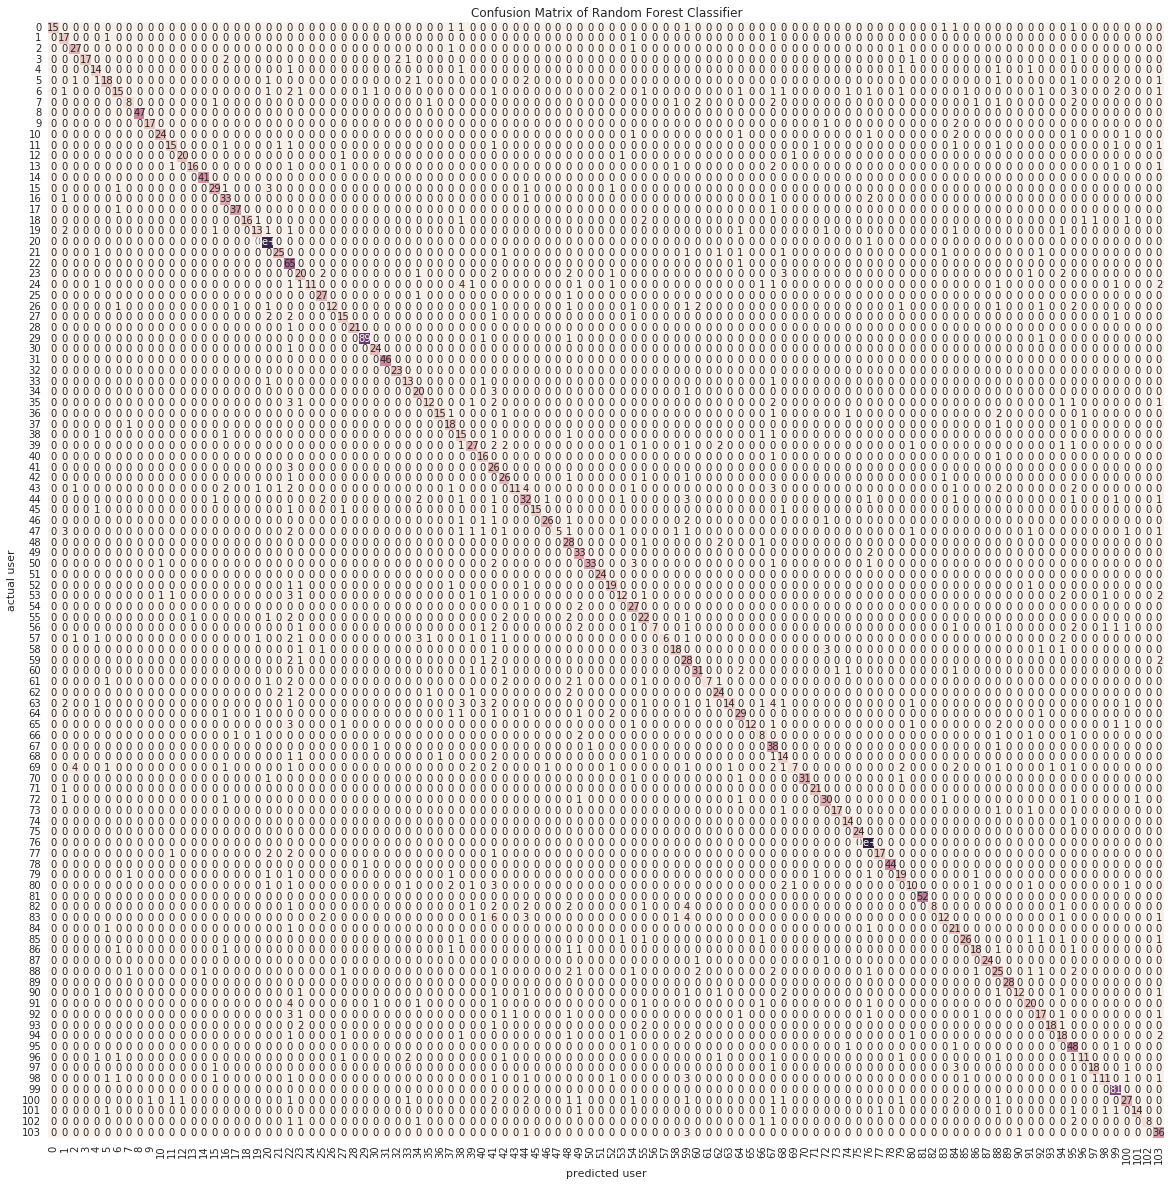

In [19]:
plt.figure(figsize=(20,20))
sns.heatmap(confusion, square=True, annot=True, cbar=False)
plt.xlabel('predicted user')
plt.ylabel('actual user')
plt.title("Confusion Matrix of Random Forest Classifier");

## BernoulliNB
Trying a different type of model known to be good for text classification.

In [20]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(preprocessor=process)),
    ('bnb', BernoulliNB(class_prior=None)),
])

In [21]:
parameters = {
    'tfidf__max_df': (0.5, 0.75, 1.0),
    'tfidf__max_features': (None, 7500, 10000, 15000),
    'tfidf__ngram_range': ((1, 1), (1, 2), (1, 3)),  # unigrams or bigrams
    'tfidf__norm': ('l1', 'l2'),
}

In [22]:
grid_search2 = GridSearchCV(pipeline, parameters, n_jobs=4, verbose=1, cv=4)

In [23]:
grid_search2.fit(X_train, y_train)

Fitting 4 folds for each of 72 candidates, totalling 288 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  5.1min
[Parallel(n_jobs=4)]: Done 288 out of 288 | elapsed:  7.7min finished


GridSearchCV(cv=4, error_score='raise',
       estimator=Pipeline(steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2',
        preprocessor=<function proces... vocabulary=None)), ('bnb', BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True))]),
       fit_params={}, iid=True, n_jobs=4,
       param_grid={'tfidf__ngram_range': ((1, 1), (1, 2), (1, 3)), 'tfidf__max_df': (0.5, 0.75, 1.0), 'tfidf__max_features': (None, 7500, 10000, 15000), 'tfidf__norm': ('l1', 'l2')},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=1)

In [24]:
grid_search2.best_params_

{'tfidf__max_df': 0.75,
 'tfidf__max_features': 7500,
 'tfidf__ngram_range': (1, 2),
 'tfidf__norm': 'l1'}

In [25]:
res_bern = grid_search2.best_estimator_

In [26]:
model = res_bern.fit(X_train, y_train)

In [27]:
y_pred_bern = model.predict(X_test)

In [28]:
accuracy_score(y_test, y_pred_bern)

0.64266263237518906

These results aren't the best. Not much else to tweak here. Next is to try the MultinomialNB classifier. 

## MultinomialNB

In [29]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(preprocessor=process)),
    ('bnb', MultinomialNB()),
])

In [30]:
parameters = {
    'tfidf__max_df': (0.5, 0.75, 1.0),
    'tfidf__max_features': (None, 7500, 10000, 15000),
    'tfidf__ngram_range': ((1, 1), (1, 2), (1, 3)),  # unigrams or bigrams
    'tfidf__norm': ('l1', 'l2')
}

In [31]:
grid_search3 = GridSearchCV(pipeline, parameters, n_jobs=4, verbose=1, cv=4)

In [32]:
grid_search3.fit(X_train, y_train)

Fitting 4 folds for each of 72 candidates, totalling 288 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  4.7min
[Parallel(n_jobs=4)]: Done 288 out of 288 | elapsed:  7.0min finished


GridSearchCV(cv=4, error_score='raise',
       estimator=Pipeline(steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2',
        preprocessor=<function proces...rue,
        vocabulary=None)), ('bnb', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]),
       fit_params={}, iid=True, n_jobs=4,
       param_grid={'tfidf__ngram_range': ((1, 1), (1, 2), (1, 3)), 'tfidf__max_df': (0.5, 0.75, 1.0), 'tfidf__max_features': (None, 7500, 10000, 15000), 'tfidf__norm': ('l1', 'l2')},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=1)

In [33]:
grid_search3.best_params_

{'tfidf__max_df': 0.5,
 'tfidf__max_features': None,
 'tfidf__ngram_range': (1, 3),
 'tfidf__norm': 'l2'}

In [34]:
res_multi = grid_search3.best_estimator_

In [35]:
model = res_multi.fit(X_train, y_train)

In [36]:
y_pred_multi = model.predict(X_test)

In [37]:
accuracy_score(y_test, y_pred_multi)

0.46444780635400906

Results were unsatisfactory. Going back to RandomForestClassifier to further tweak the hyperparameters.